# Human Face Detector


We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

## Steps

* [Step 0](#step0): Import Dataset
* [Step 1](#step1): Load Classifier
* [Step 2](#step2): Write a Human Face Detector
* [Step 3](#step3): Test Classifier
* [Step 4](#step4): Import Coffe Models
* [Step 5](#step5): Test Coffe Models

<a id='step0'></a>
## Step 0: Import Dataset

In [1]:
import numpy as np
from glob import glob

# load filenames
human_files = np.array(glob("./lfw/*/*"))
np.random.shuffle(human_files)
# print number of images in the dataset
print('There are %d images.' % len(human_files))

There are 235 images.


<a id='step1'></a>
## Step 1: Load Classifier

('Number of faces detected:', 1)


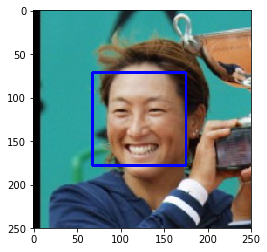

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def get_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return faces

img = cv2.imread(human_files[33])

faces = get_faces(img)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) 

cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('Number of faces detected:', len(faces))

plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.



<a id='step2'></a>
## Step 2: Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    faces = get_faces(img)
    return len(faces) > 0

<a id='step3'></a>
## Step 3: Test Classifier

In [4]:
n = 200
human_files_short = human_files[:n]
humans_in_human_files = 0.0

for i in range(n):
    if(face_detector(human_files_short[i])):
        humans_in_human_files += 1

print('Human detection in human images: {}%'.format(humans_in_human_files/n*100))

Human detection in human images: 97.0%


<a id='step4'></a>
## Step 4: Import Coffe Models

In [5]:
def load_caffe_models():
    age_net = cv2.dnn.readNetFromCaffe('./caffe/deploy_age.prototxt', './caffe/age_net.caffemodel')
    gender_net = cv2.dnn.readNetFromCaffe('./caffe/deploy_gender.prototxt', './caffe/gender_net.caffemodel')
    return(age_net, gender_net)

age_net, gender_net = load_caffe_models()

In [6]:
age_list = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']

def predict_age(blob):
    age_net.setInput(blob)
    age_preds = age_net.forward()
    age = age_list[age_preds[0].argmax()]
    return age

In [7]:
gender_list = ['Male', 'Female']

def predict_gender(blob):
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = gender_list[gender_preds[0].argmax()]
    return gender

<a id='step5'></a>
## Step 5: Test Coffe Models

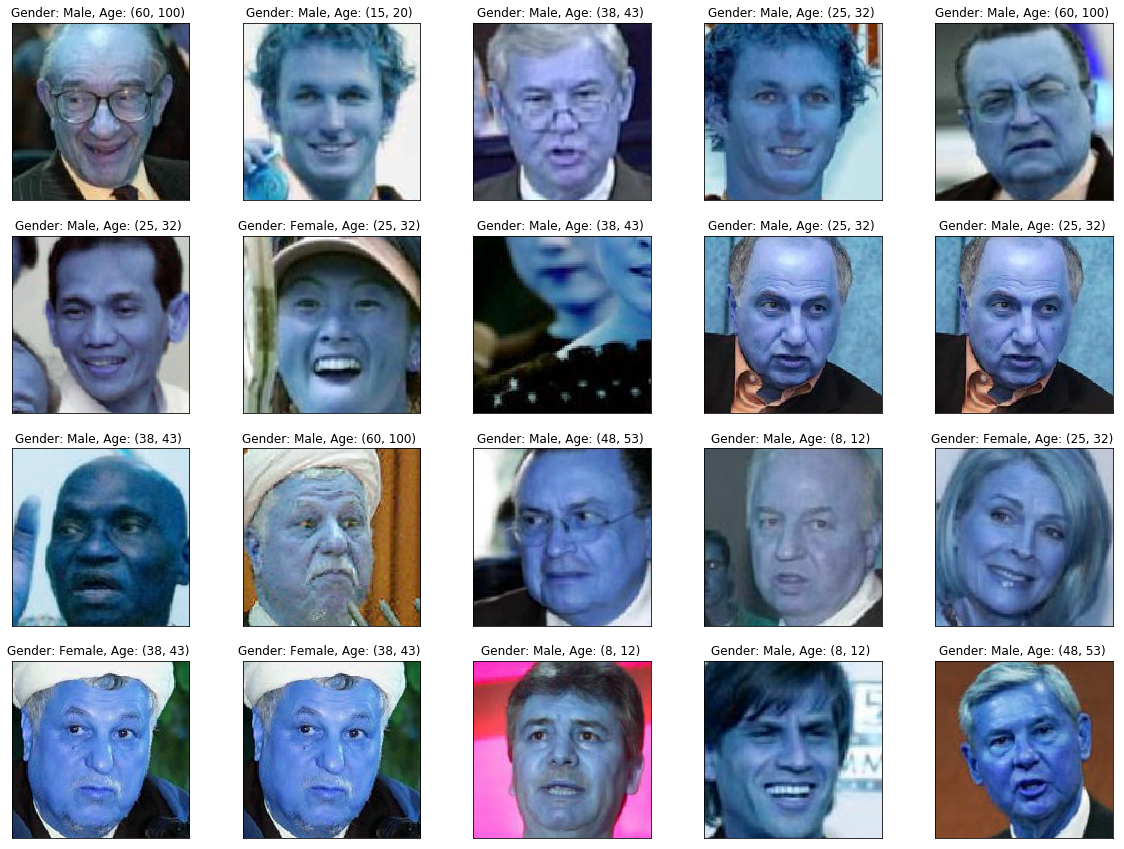

In [10]:
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
img_size = (227, 227)
d = 20

fig = plt.figure(figsize=(20, 15))

for idx, image in enumerate(human_files[:20]):
    img = cv2.imread(image)
    faces = get_faces(img)[:1]
    
    for (x, y, w, h) in faces:
        face_img = img[y-d:y+h+d, x-d:x+w+d].copy()
        cv2.rectangle(img, (x-d, y-d), (x+w+d, y+h+d), (255, 255, 0), 2)
        blob = cv2.dnn.blobFromImage(face_img, 1, img_size, MODEL_MEAN_VALUES, swapRB=False)
        gender = predict_gender(blob)
        age = predict_age(blob)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(face_img)
    plt.title('Gender: {}, Age: {} '.format(gender, age))